In [1]:
from __future__ import print_function
%matplotlib inline
import os
from collections import OrderedDict
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
from sklearn.metrics import classification_report
from skimage.util import random_noise
import decimal
import captum
from captum.attr import IntegratedGradients
from sklearn.metrics import mean_squared_error
import pandas as pd
import datetime
import random
from IPython.display import clear_output
from dateutil.parser import parse
from random import randrange
from statistics import mean
import seaborn as sns
import sys
import pickle
import math
sys.path.append("/home/rgopikrishna/CommunicationNetworkAnomalyDetection/source/notebooks_new/main/")
import utils
sys.path.append("/home/rgopikrishna/CommunicationNetworkAnomalyDetection/source/notebooks_new/main/advunetae_contrad")
sys.path.append("/home/rgopikrishna/CommunicationNetworkAnomalyDetection/source/notebooks_new/main/advunetae_contrad/run2/")
from model import Generator,Discriminator
from utils import weights_init,gradient_penalty_,augment_bt
import pdb

In [2]:
tag = 'noprojection32_anomaug'
ngpu = 1
nc = 1
batch_size = 32
lr = 1e-4
lambda_gp = 10
critic_iterations = 5
# weight_clip = 0.01

outpath = '/home/rgopikrishna/CommunicationNetworkAnomalyDetection/source/notebooks_new/main/advunetae_contrad/'

In [3]:
train = np.load('/home/rgopikrishna/vrif/data/train.npy')
train_90 = np.load('/home/rgopikrishna/vrif/data/train_90.npy')
train_180 = np.load('/home/rgopikrishna/vrif/data/train_180.npy')

In [4]:
train = np.concatenate([train,train_90,train_180],axis=1)

In [5]:
train.shape

(11670, 3, 80, 80)

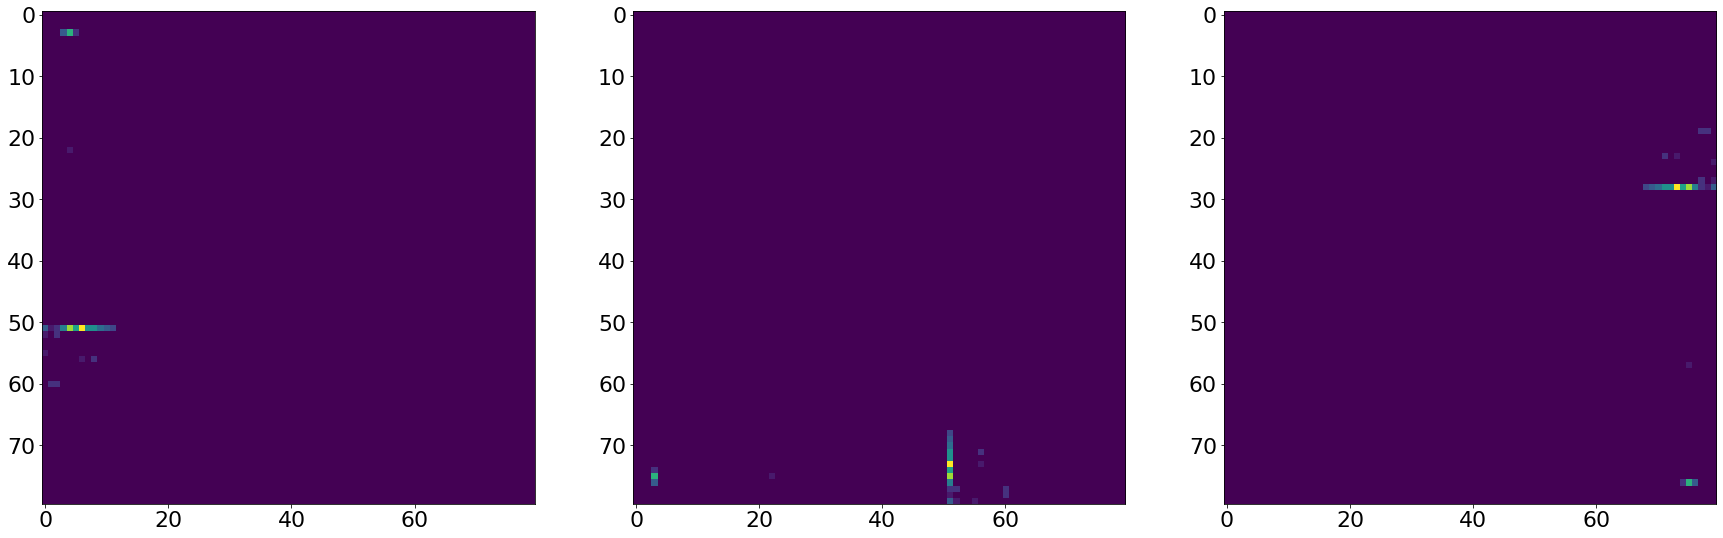

In [6]:
fig,ax = plt.subplots(1,3,figsize=(30,10))
ax[0].imshow(train[0,0])
ax[1].imshow(train_90[0,0])
ax[2].imshow(train_180[0,0])

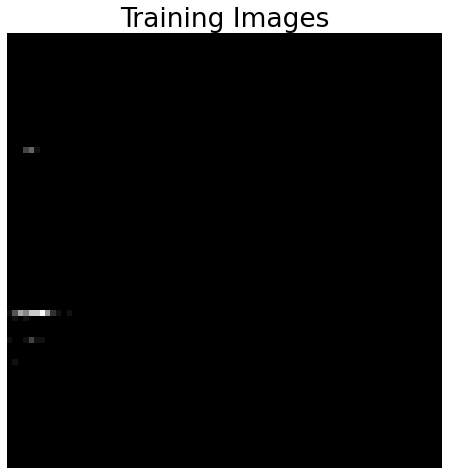

In [7]:
# Create the dataloader
dataloader_train = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                         shuffle=True)

# Decide which device we want to run on
device = torch.device("cuda:3" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader_train))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0,0], padding=2,normalize=True).cpu(),(1,2,0)))

In [8]:
train.shape

(11670, 3, 80, 80)

In [9]:
def cont_pos(out1, out2, out3, temperature=0.1, distributed=False):

# hidden

    return d_loss

def cont_loss(out1, out2, temperature=0.1, distributed=False):

# hidden

    return d_loss

def gradient_penalty(D, images, gen_images):
    batch_size = images.size(0)
    _device = images.device

    # Calculate interpolation
    alpha = torch.rand(batch_size, 1, 1, 1)
    alpha = alpha.expand_as(images)
    alpha = alpha.to(_device)

    interpolated = alpha * images.data + (1 - alpha) * gen_images.data
    interpolated = Variable(interpolated, requires_grad=True)
    interpolated = interpolated.to(_device)

    # Calculate probability of interpolated examples
    prob_interpolated = D(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(prob_interpolated.size()).to(_device),
                           create_graph=True, retain_graph=True)[0]

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(batch_size, -1)

    # Return gradient penalty
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

In [10]:
netG = Generator().to(device)
netG.apply(weights_init)

netD = Discriminator().to(device)
netD.apply(weights_init)

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.0,0.9))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.0,0.9))

In [11]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
D_disc_losses = []
D_con_pos_losses = []
D_con_neg_losses = []
iters = 0
num_epochs = 100
critic_real_val = []
critic_fake_val = []
reconstructionerror = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
#     clear_output(wait=True)
    fakes = []
    inputs = []
    fake_lastitem = None
    # For each batch in the dataloader
    for i, data in enumerate(dataloader_train):
        
#         print('Epoch:,',epoch+1,'__________________________',i,'_____________________________')
        
        X = Variable(data[:,0,:].unsqueeze(1).float()).to(device)
        bsize = X.size(0)
        anom1 = augment_bt(X)
        inputs.append(X.cpu().data.numpy())
        # Update discriminator
        for idx,_ in enumerate(range(critic_iterations)):
            
#             print('Critic iteration',idx)
            
            noise = torch.randn(X.size(0),1, 10, 10, device=device)
            fake = netG(noise,X)
            if idx==critic_iterations-1:
                fakes.append(fake.cpu().data.numpy())

            critic_real,proj_real = netD(X,penul=True)
            critic_fake,proj_fake = netD(fake,penul=True)
            critic_anom1,proj_anom1 = netD(anom1,penul=True)
            
            critic_real = critic_real.reshape(-1)
            critic_fake = critic_fake.reshape(-1)
            critic_anom1 = critic_anom1.reshape(-1)
            
            proj_real = proj_real.reshape(bsize,-1)
            proj_fake = proj_fake.reshape(bsize,-1)
            proj_anom1 = proj_anom1.reshape(bsize,-1)
            
            L_cont_neg = cont_loss(proj_real,proj_anom1)
            
            gp = gradient_penalty(netD, X, fake)
            L_disc = (-(torch.mean(critic_real) - torch.mean(critic_fake))) + lambda_gp*gp 
            lossD = L_disc + L_cont_neg
            critic_real_val = torch.mean(critic_real).item()
            critic_fake_val = torch.mean(critic_fake).item()
            netD.zero_grad()
            lossD.backward(retain_graph = True)
            optimizerD.step()

        # Update Generator
        output = netD(fake)
        output = output.reshape(-1)
        lossG = -torch.mean(output)
        netG.zero_grad()
        lossG.backward()
        optimizerG.step()
        
        # Output training stats
        if i % 25 == 0:
            print('[%d/%d] - Loss G: %.4f, Loss D: %.4f, Loss disc: %.4f, Loss cont neg: %.4f, critic(real):%.4f, critic(fake):%.4f' % (epoch+1,num_epochs,lossG.item(),lossD.item(),L_disc.item(),L_cont_neg.item(),critic_real_val,critic_fake_val))
        
        fig,ax = plt.subplots(1,2,figsize=(10,5))
        ax[1].imshow(fake[0,0].cpu().data.numpy())
        ax[0].imshow(X[0,0].cpu().data.numpy())
        fig.savefig(outpath + 'images/generatedimages/realfake_epoch_{}_{}.png'.format(epoch,tag))
        plt.close()
        
    if epoch % 5 == 0:
        torch.save(netG.state_dict(),outpath + '/models/g_fm_{}_{}.pth'.format(str(datetime.date.today()),tag))
        torch.save(netD.state_dict(),outpath + '/models/d_fm_{}_{}.pth'.format(str(datetime.date.today()),tag))
        
    # Save Losses for plotting later
    G_losses.append(lossG.item())
    D_losses.append(lossD.item())
    D_con_neg_losses.append(L_cont_neg.item())
        
fakes = np.concatenate(fakes)
inputs = np.concatenate(inputs)

Starting Training Loop...
[1/100] - Loss G: -0.5535, Loss D: 91294.4766, Loss disc: 90086.3125, Loss cont neg: 1208.1603, critic(real):-1.0407, critic(fake):0.5437


/home/rgopikrishna/CommunicationNetworkAnomalyDetection/source/notebooks_new/main/utils.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images[image,channel,row,col] = intensity*torch.tensor(random.uniform(data_min, data_max))


[1/100] - Loss G: -3.6403, Loss D: 2279.2898, Loss disc: 389.0795, Loss cont neg: 1890.2102, critic(real):0.8424, critic(fake):3.6528
[1/100] - Loss G: -2.1046, Loss D: 232.6703, Loss disc: 179.2181, Loss cont neg: 53.4522, critic(real):1.7539, critic(fake):2.1418
[1/100] - Loss G: -1.8667, Loss D: 91.5121, Loss disc: 41.0813, Loss cont neg: 50.4308, critic(real):1.7532, critic(fake):1.8759
[1/100] - Loss G: -1.6982, Loss D: 231.5651, Loss disc: 62.7205, Loss cont neg: 168.8446, critic(real):1.6927, critic(fake):1.7078
[1/100] - Loss G: -1.4904, Loss D: 115.1283, Loss disc: 88.8081, Loss cont neg: 26.3202, critic(real):1.4411, critic(fake):1.5016
[1/100] - Loss G: -1.3541, Loss D: 49.9620, Loss disc: 5.9029, Loss cont neg: 44.0591, critic(real):1.4237, critic(fake):1.3603
[1/100] - Loss G: -1.2248, Loss D: 41.8862, Loss disc: 17.7807, Loss cont neg: 24.1055, critic(real):1.3795, critic(fake):1.2520
[1/100] - Loss G: -1.0811, Loss D: 61.4765, Loss disc: 23.5674, Loss cont neg: 37.9090, 

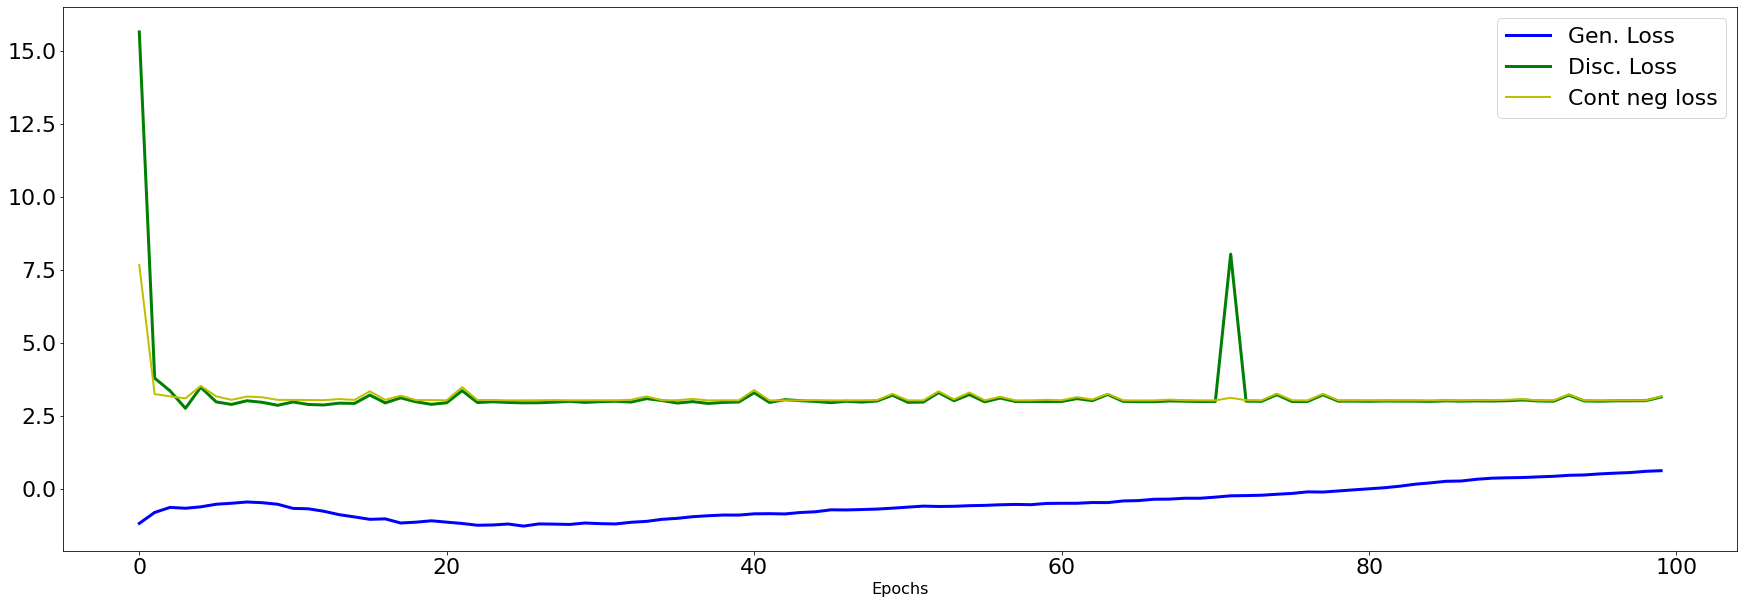

In [16]:
fig,ax=plt.subplots(1,1,figsize=(30,10))
ax.plot(pd.Series(G_losses),c='b',lw=3)
ax.plot(pd.Series(D_losses),c='g',lw=3)
ax.plot(pd.Series(D_con_neg_losses),c='y',lw=2)
ax.legend(['Gen. Loss','Disc. Loss', 'Cont neg loss'])
ax.set_xlabel("Epochs",fontsize=16)
fig.savefig(outpath+'/images/losses_{}_{}.png'.format(str(datetime.date.today()),tag))

In [17]:
print(len(inputs),len(fakes))
np.save(outpath + 'images/generatedimages/numpys/fake_{}_train_{}.npy'.format(str(datetime.date.today()),tag),fakes)
np.save(outpath + 'images/generatedimages/numpys/real_{}_train_{}.npy'.format(str(datetime.date.today()),tag),inputs)

11670 11670


In [18]:
pd.Series(D_losses)[:30]

0     15.668591
1      3.809090
2      3.373966
3      2.776423
4      3.496315
5      2.995726
6      2.908696
7      3.034261
8      2.980877
9      2.879134
10     2.992757
11     2.906599
12     2.890243
13     2.952065
14     2.943212
15     3.229585
16     2.960561
17     3.134284
18     2.998641
19     2.912144
20     2.966921
21     3.379935
22     2.973735
23     3.000138
24     2.976751
25     2.963386
26     2.966115
27     2.987702
28     3.014337
29     2.977728
dtype: float64

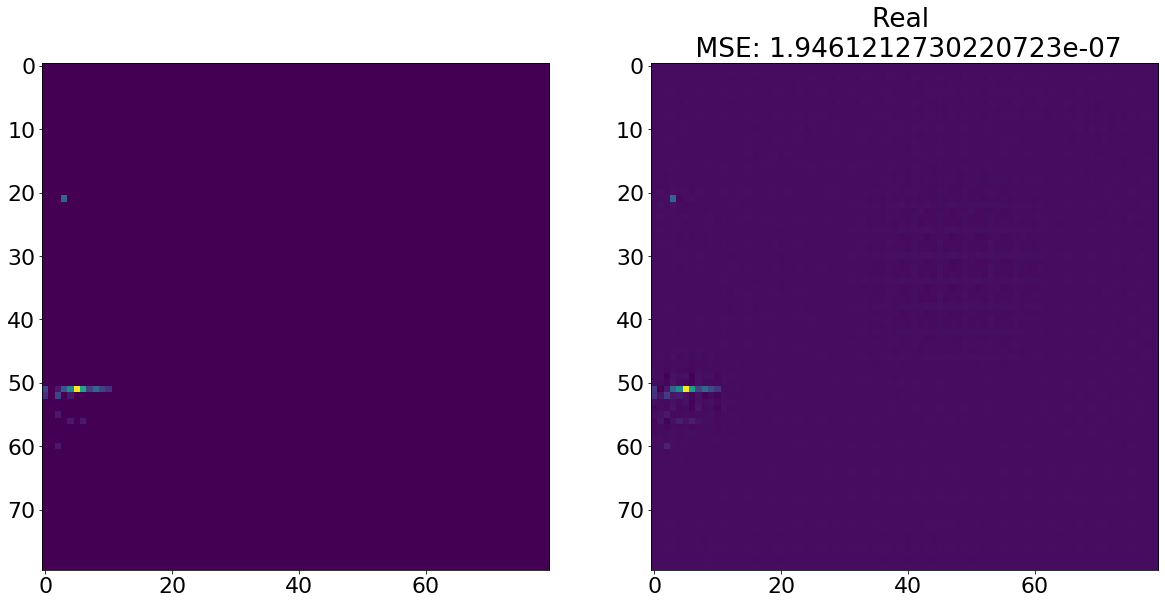

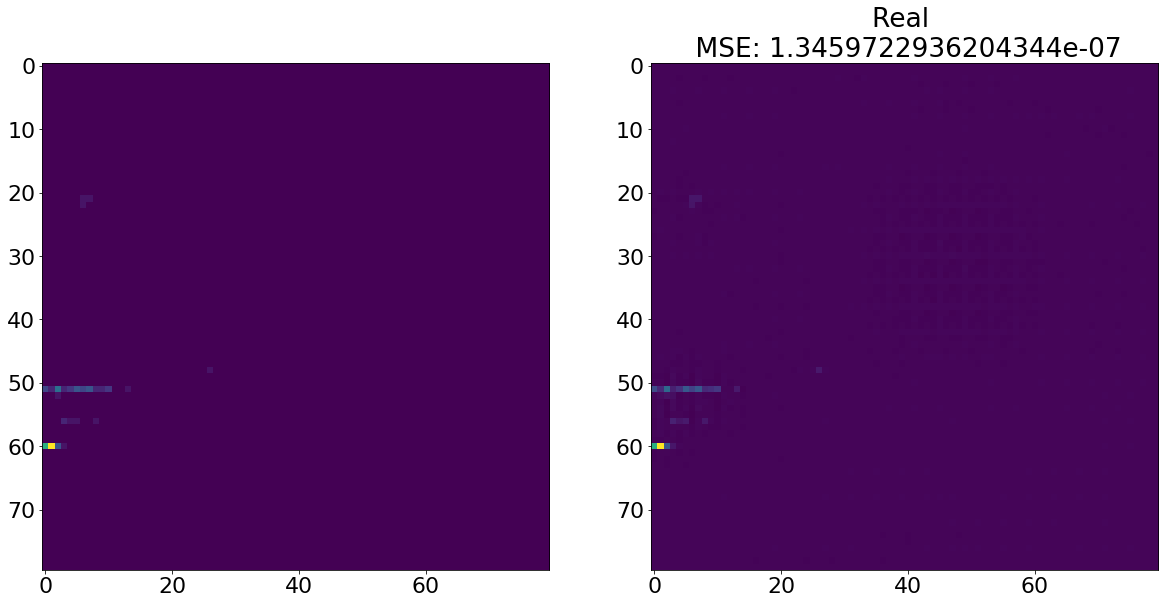

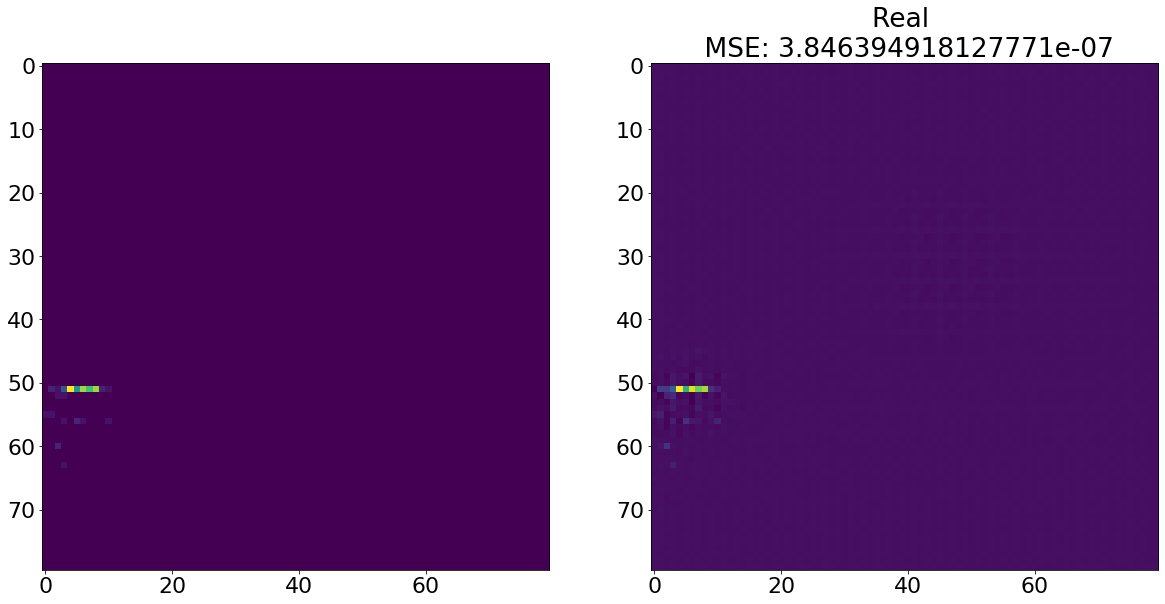

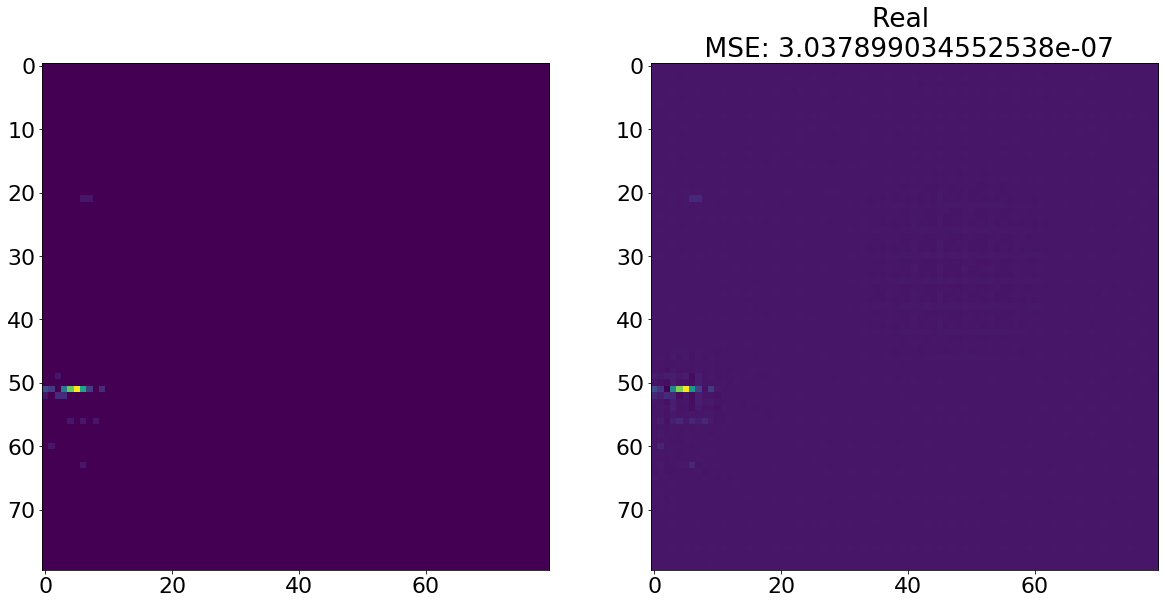

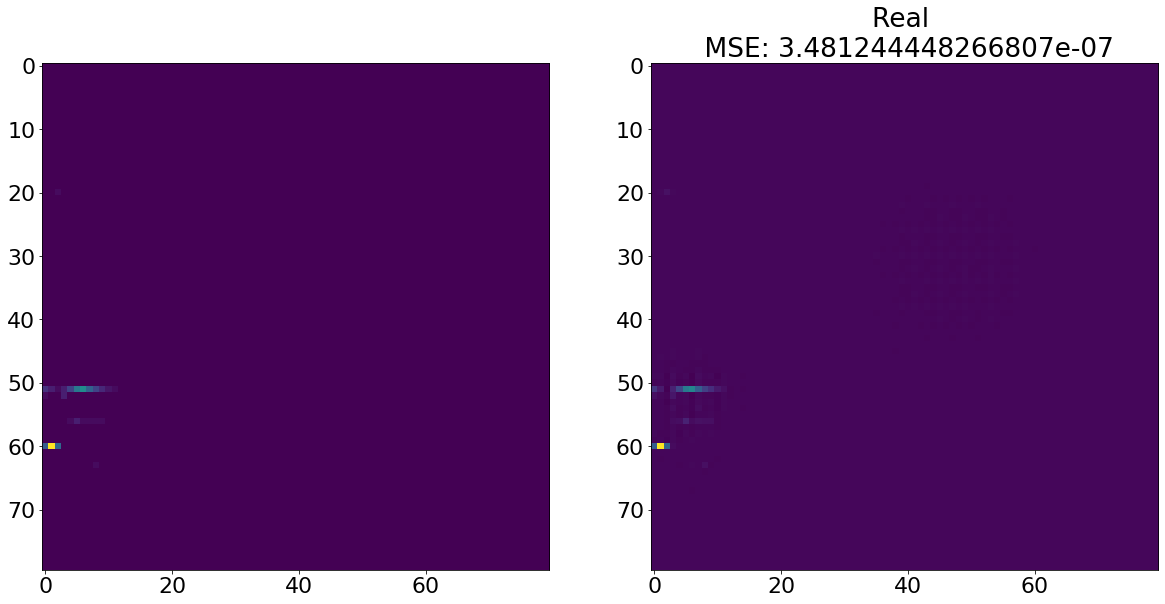

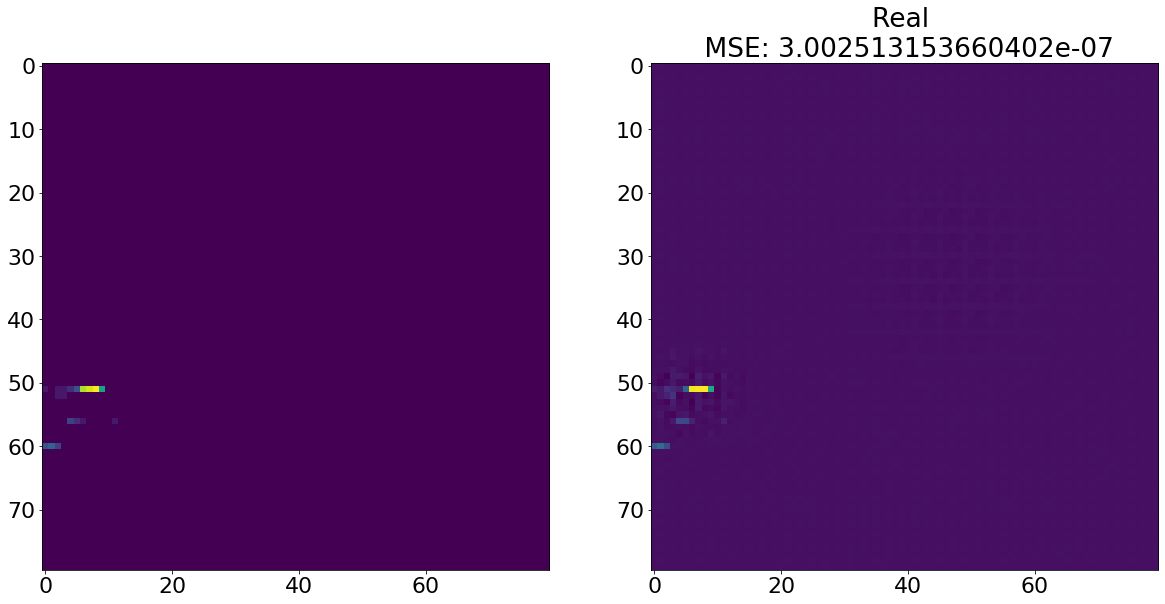

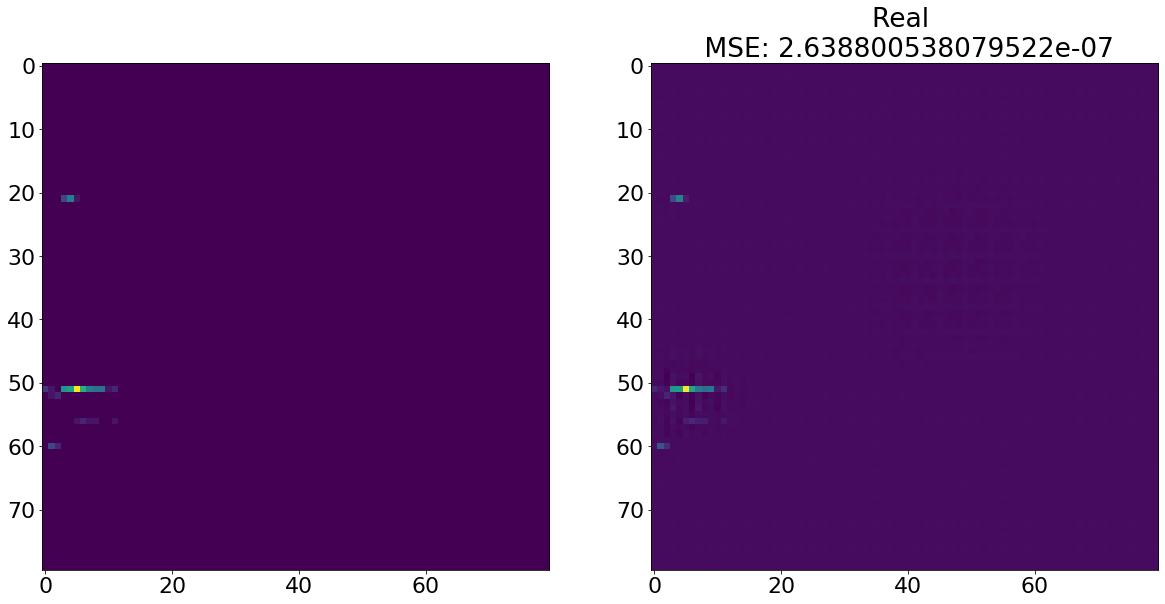

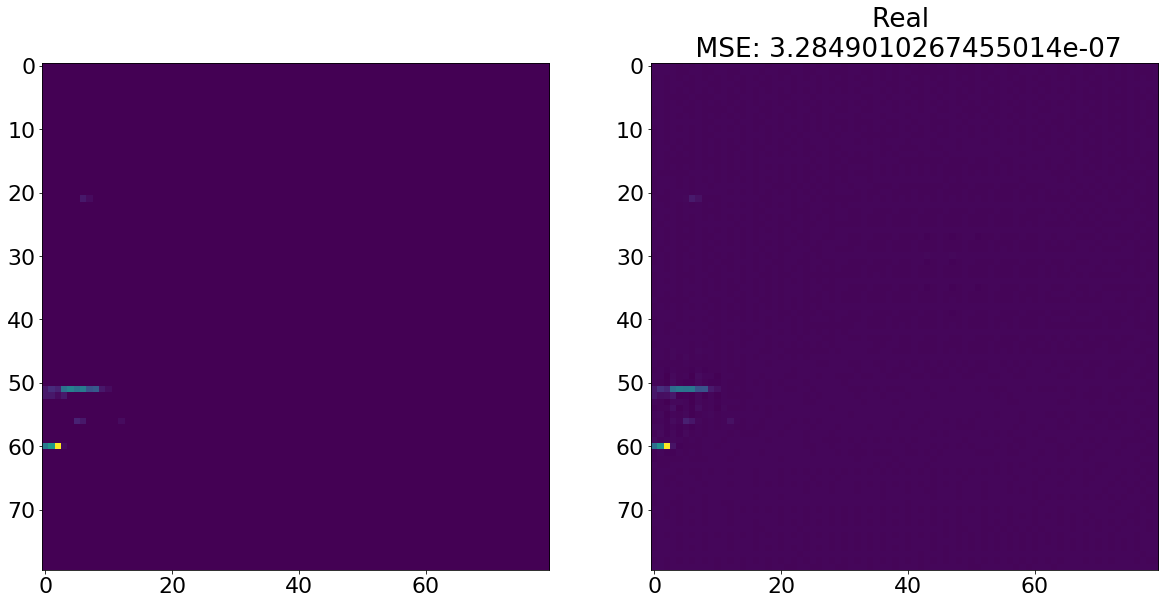

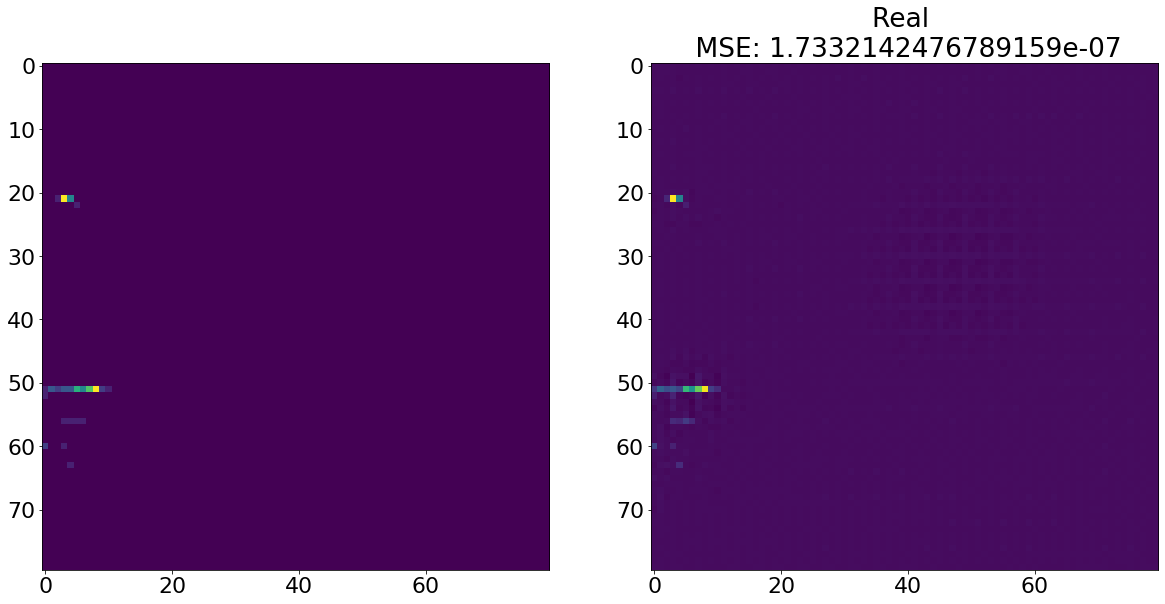

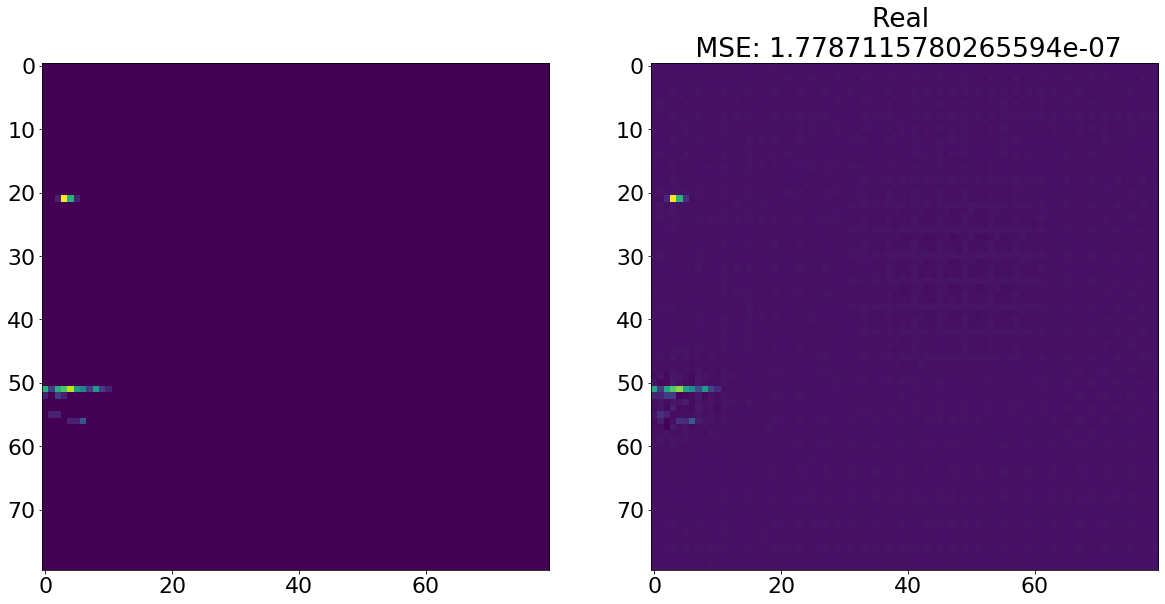

In [19]:
for i in range(len(fakes)-10,len(fakes)):
    fig,ax = plt.subplots(1,2,figsize=(20,10))
    ax[1].imshow(fakes[i,0])
    ax[0].imshow(inputs[i,0])
    ax[1].set_title('Real \n MSE: {}'.format(mean_squared_error(fakes[i,0],inputs[i,0])))
    fig.savefig(outpath + 'images/generatedimages/realfake_{}_{}_{}.png'.format(str(datetime.date.today()),i,tag))

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(30,10))
ax.plot(pd.Series(G_losses)[10:],c='b',lw=3)
ax.plot(pd.Series(D_losses)[10:],c='g',lw=3)

ax.legend(['Gen. Loss','Disc. Loss'])
ax.set_xlabel("Epochs",fontsize=16)
fig.savefig(outpath+'/images/fm_losses_{}_{}.png'.format(str(datetime.date.today()),tag))?

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(30,10))
ax.loglog(abs(pd.Series(G_losses)[10:]),c='b',lw=3)
ax.loglog(abs(pd.Series(D_losses)[10:]),c='g',lw=3)

ax.legend(['Gen. Loss','Disc. Loss'])
ax.set_xlabel("Epochs",fontsize=16)
fig.savefig(outpath+'/images/fm_loglog_losses_{}_{}.png'.format(str(datetime.date.today()),tag))